## Preparation

You need to setup the TECHIN515 virtual environment to run this lab 

# TECHIN 515: Quantization and Pruning Methods

In this lab, we will first go through three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3)Integer Quantization. Then we try out strip pruning for model compression.

We will use Efficient Net (`efnet`) ML model as our base ML model and download and use `cats_vs_dogs` dataset for training and testing ML models.

Before working on the code, we will need to setup the environment. The following code will display the current version of the tensorflow if you have already installed it in your machine.

In the following we will install `tensorflow_datasets` and `tensorflow_model_optimization` libraries.

In [1]:
!pip install tensorflow_datasets

  Using cached protobuf-4.21.12-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.21.12-cp37-abi3-macosx_10_9_universal2.whl (486 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0


In [ ]:
!pip install tensorflow_model_optimization

: 

Next we will first download and load `cats_vs_dogs` dataset, load and retrain `efnet` ML model, and experiment with three (post training) quantization methods: (1) Float-16 Quantization, (2) Dynamic Range Quantization, and (3) Integer Quantization.  

The following code and material were adapted from the reference [1].

In [2]:
# Importing necessary libraries and packages.
import os
import numpy as np
import tempfile
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
%load_ext tensorboard

/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## (1) Preparing the Dataset

We can directly import the dataset from the TensorFlow Dataset (tfds). Here we will split the dataset into training, validation, and testing set with a split ratio of 0.7:0.2:0.1. The as_supervised parameter is kept True as we need the labels of the images for classification. 

In [3]:
# Downloading and Loading the CatvsDog dataset.
(train_ds, val_ds, test_ds), info = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], shuffle_files=True, as_supervised=True, with_info=True)


2025-04-15 14:17:40.676596: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]WARNING:absl:1738 images were corrupted and were skipped
2025-04-15 14:18:59.770918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset cats_vs_dogs downloaded and prepared to /Users/diyunlu/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Let us now have a look at the dataset information provided in tfds.info(). The dataset has two classes labeled as ‘cat’ and ‘dog’ with 16283, 4653, 2326 training, validation and testing images.

In [4]:
# Obtaining dataset information.
print("Number of  Classes: " + str(info.features['label'].num_classes))
print("Classes : " + str(info.features['label'].names))
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Training Images: " + str(NUM_TRAIN_IMAGES))
NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Validation Images: " + str(NUM_VAL_IMAGES))
NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Testing Images: " + str(NUM_TEST_IMAGES))

Number of  Classes: 2
Classes : ['cat', 'dog']
Training Images: 16283
Validation Images: 4653
Testing Images: 2326


The function tfds.visualization.show_examples() function displays images and their corresponding labels. It comes very handy when we want to visualize a few images in a single line of code!

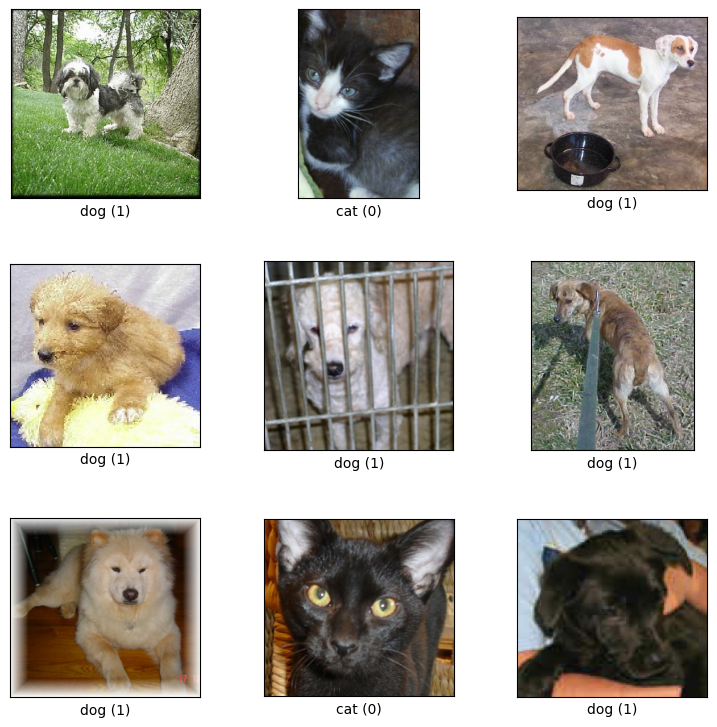

In [6]:
# Visualizing the training dataset.import tempfile
vis = tfds.visualization.show_examples(train_ds, info)

We have chosen 16 as batch size and 224×224 as image size so that the dataset can be processed effectively and efficiently. To prepare the dataset, the images have been resized accordingly.
Let’s also make sure to use buffered prefetching to yield data from the disk. Prefetching overlaps the preprocessing and model execution of a training step. Doing so reduces the step time to the training and the time it takes to extract the data.

In [7]:
# Defining batch-size and input image size.
batch_size = 16
img_size = [224, 224]# Resizing images in the dataset.
train_ds_ = train_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
val_ds_ = val_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)
test_ds_ = test_ds.cache().map(lambda x, y: (tf.image.resize(x, img_size), y)).batch(batch_size).prefetch(buffer_size=10)

To feed images to the TF Lite model, we need to extract the test images and their labels. We will store them into variables and feed them to TF Lite for evaluation.

In [8]:
# Extracting and saving test images and labels from the test dataset.
test_images = []
test_labels = []
for image, label in test_ds_.take(len(test_ds_)).unbatch():
    test_images.append(image)
    test_labels.append(label)

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


## (2) Loading the Model

We have chosen the EfiicientNet B0 model pre-trained on the imagenet dataset for image classification purposes. EfficientNet is a state-of-the-art image classification model. It significantly outperforms other ConvNets. 

Let us import the model form tf.keras.applications().  The last layer has been removed by setting include_top = False .We have set the input image size to 224×224 pixels and kept the pooling layer to be GlobalMaxPooling2D. Let’s load the model and unfreeze all the layers to make them trainable.

In [9]:
# Defining the model architecture.
efnet = tf.keras.applications.EfficientNetB0(include_top = False, weights ='imagenet', input_shape = (224, 224, 3), pooling = 'max')# Unfreezing all the layers of the model.
for layer in efnet.layers:
    set_trainable = True

16719872/16705208 [==============================] - 1s 0us/step


Now, we will add a Dense layer to the pre-trained model and train it. This layer will become the last layer, or the inference layer. We will also add Dropout and BatchNormalization to reduce overfitting.

In [10]:
# Adding Dense, BatchNormalization and Dropout layers to the base model.
x = Dense(512, activation='relu')(efnet.output)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

## (3) Compiling the Model

We are ready to compile the model. We have used Adam Optimizer with an initial learning rate of 0.0001, sparse categorical cross-entropy as the loss function, and accuracy as the metric. Once compiled, we check the model summary.

In [11]:
# Defining the input and output layers of the model.
model = Model(inputs=efnet.input, outputs=predictions)
 
# Compiling the model.
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ["accuracy"])
 
# Obtaining the model summary.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

We are using Model Saving Callback and the Reduce LR Callback.

(i) Model Saving Callback saves the model with the best validation accuracy

(ii) Reduce LR Callback reduces the learning rate by a factor of 0.1 if validation loss remains the same for three consecutive epochs.

In [12]:
# Defining file path of the saved model.
filepath = './model.h5'
 
# Defining Model Save Callback and Reduce Learning Rate Callback.
model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch")
 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, min_delta=5*1e-3,min_lr =5*1e-9,)
 
callback = [model_save, reduce_lr]

### Discussion:
- What is the input size?<br>
  The input size of the image is 224x224, and the input layer size is a 3-layer with dimension of 224x224.
- Based on model summary, name two examples of layers used in the architecture<br>
  Normalization and Convolution


## (4) Training the Model

The method `model.fit()` is called to train the model. We pass the training and validation datasets and train the model for 15 epochs.

In [14]:
# Training the model for 15 epochs. 
# ---> epoch = 3 for testing the code and saving time during the lab
# ---> epoch = 15 recommended for better results 
model.fit(train_ds_, epochs=15, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callback)

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8006

2025-04-15 14:25:15.622864: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


63/63 [==============================] - 154s 2s/step - loss: 0.4813 - accuracy: 0.8006 - val_loss: 0.2808 - val_accuracy: 0.9201 - lr: 1.0000e-04
Epoch 2/15
63/63 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9107

2025-04-15 14:27:38.316419: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 143s 2s/step - loss: 0.2371 - accuracy: 0.9107 - val_loss: 0.1498 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 3/15
63/63 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9484

2025-04-15 14:30:00.847770: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 143s 2s/step - loss: 0.1363 - accuracy: 0.9484 - val_loss: 0.0955 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 4/15
63/63 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9454

2025-04-15 14:32:23.465516: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 143s 2s/step - loss: 0.1370 - accuracy: 0.9454 - val_loss: 0.0827 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 5/15
63/63 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9544

2025-04-15 14:34:59.949959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 157s 2s/step - loss: 0.1302 - accuracy: 0.9544 - val_loss: 0.0783 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 6/15
12/63 [====>.........................] - ETA: 1:51 - loss: 0.1253 - accuracy: 0.9427

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


63/63 [==============================] - 145s 2s/step - loss: 0.1365 - accuracy: 0.9544 - val_loss: 0.0887 - val_accuracy: 0.9792 - lr: 1.0000e-04


2025-04-15 14:37:25.903085: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7/15
20/63 [========>.....................] - ETA: 1:30 - loss: 0.1242 - accuracy: 0.9469

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


63/63 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9593

2025-04-15 14:39:47.693926: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


63/63 [==============================] - 142s 2s/step - loss: 0.1129 - accuracy: 0.9593 - val_loss: 0.0620 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 8/15
63/63 [==============================] - 146s 2s/step - loss: 0.1272 - accuracy: 0.9484 - val_loss: 0.0413 - val_accuracy: 0.9757 - lr: 1.0000e-04


2025-04-15 14:42:14.114198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/15
35/63 [===============>..............] - ETA: 59s - loss: 0.1266 - accuracy: 0.9500 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


63/63 [==============================] - 142s 2s/step - loss: 0.1145 - accuracy: 0.9573 - val_loss: 0.0378 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-15 14:44:36.436470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/15
63/63 [==============================] - 146s 2s/step - loss: 0.0878 - accuracy: 0.9702 - val_loss: 0.0474 - val_accuracy: 0.9722 - lr: 1.0000e-04


2025-04-15 14:47:02.594529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11/15
63/63 [==============================] - 143s 2s/step - loss: 0.1101 - accuracy: 0.9563 - val_loss: 0.0388 - val_accuracy: 0.9757 - lr: 1.0000e-04


2025-04-15 14:49:25.581312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12/15
63/63 [==============================] - 141s 2s/step - loss: 0.0820 - accuracy: 0.9692 - val_loss: 0.0489 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-15 14:51:46.556153: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13/15
63/63 [==============================] - 146s 2s/step - loss: 0.0993 - accuracy: 0.9643 - val_loss: 0.0532 - val_accuracy: 0.9792 - lr: 1.0000e-04


2025-04-15 14:54:12.435870: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14/15
63/63 [==============================] - 146s 2s/step - loss: 0.1003 - accuracy: 0.9663 - val_loss: 0.0634 - val_accuracy: 0.9688 - lr: 1.0000e-04


2025-04-15 14:56:38.864590: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 15/15
20/63 [========>.....................] - ETA: 1:31 - loss: 0.0842 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


60/63 [===========================>..] - ETA: 6s - loss: 0.0768 - accuracy: 0.9677

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


63/63 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9653
Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
63/63 [==============================] - 143s 2s/step - loss: 0.0854 - accuracy: 0.9653 - val_loss: 0.0681 - val_accuracy: 0.9826 - lr: 1.0000e-04


2025-04-15 14:59:01.694308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-15 14:59:01.751151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## (5) Evaluating the Model

Done training! Let’s check the model’s performance on the test set.

In [15]:
# Evaluating the model on the test dataset.
_, baseline_model_accuracy = model.evaluate(test_ds_, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy*100)

Baseline test accuracy: 98.62424731254578


### Discussion:
- Report the model performance when trained for 3 epochs and 15 epochs. 
  <br>
  The model reached the accuracy of 96% when trained for 3 epochs and 98.6%for 15 epochs
- Briefly explain your observation.
 <br>
 The training process went through a oscillitating stages when reaching the 15th epochs, and the accuracy actually had no such large space for the accuracy to increase. In the meantime, you need to worry about if the model will overfit.  
- If you were to train the model, will you train the model for 3 epochs or 15 epochs? Justify your choice.
  <br>
  I will choose to train 3 epochs first to ensure everything goes right. 3 epochs will not cost too much time and I can still train based on the trained model weights.

## (6) Float-16 Quantization
In Float-16 quantization, weights are converted to 16-bit floating-point values. 

In [16]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
 
# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
 
# Converting the model.
tflite_fp16_model = converter.convert()
 
# Saving the model.
with open('./fp_16_model.tflite', 'wb') as f:
    f.write(tflite_fp16_model)

2025-04-15 15:00:35.767678: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpo8m8lkpm/assets


INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpo8m8lkpm/assets
2025-04-15 15:02:11.150998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-15 15:02:11.151052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-15 15:02:11.153427: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpo8m8lkpm
2025-04-15 15:02:11.219880: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-15 15:02:11.219903: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpo8m8lkpm
2025-04-15 15:02:11.597596: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-15 15:02:13.182784: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

We have passed the Float 16 quantization the `converter.target_spec.supported_type` to specify the type of quantization. The rest of the code remains the same for a general way of conversion for the TF Lite Model. In order to get model accuracy, let’s first define evaluate() function that takes in tflite model and returns model accuracy.

In [34]:
# #Function for evaluating TF Lite Model over Test Images
# def evaluate(interpreter):
#     prediction= []
#     input_index = interpreter.get_input_details()[0]["index"]
#     output_index = interpreter.get_output_details()[0]["index"]
#     input_format = interpreter.get_output_details()[0]['dtype']
    
#     for i, test_image in enumerate(test_images):
#         if i % 100 == 0:
#             print('Evaluated on {n} results so far.'.format(n=i))
#         test_image = np.expand_dims(test_image, axis=0).astype(input_format)
#         interpreter.set_tensor(input_index, test_image)

#     # Run inference.
#     interpreter.invoke()
#     output = interpreter.tensor(output_index)
#     predicted_label = np.argmax(output()[0])
#     prediction.append(predicted_label)
    
#     print('\n')
#     # Comparing prediction results with ground truth labels to calculate accuracy.
#     prediction = np.array(prediction)
#     accuracy = (prediction == test_labels).mean()
#     return accuracy

def evaluate(interpreter):
    predictions = []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_dtype = interpreter.get_input_details()[0]['dtype']

    for i, test_image in enumerate(test_images):
        if i % 100 == 0:
            print('Evaluated on {n} samples so far.'.format(n=i))

        test_image = np.expand_dims(test_image, axis=0).astype(input_dtype)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        predictions.append(predicted_label)

    predictions = np.array(predictions)
    accuracy = (predictions == test_labels).mean()
    return accuracy


Check this FP-16 Quantized TF Lite’s model performance on the Test Set. 

In [43]:
# Passing the FP-16 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('fp_16_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 samples so far.
Evaluated on 100 samples so far.
Evaluated on 200 samples so far.
Evaluated on 300 samples so far.
Evaluated on 400 samples so far.
Evaluated on 500 samples so far.
Evaluated on 600 samples so far.
Evaluated on 700 samples so far.
Evaluated on 800 samples so far.
Evaluated on 900 samples so far.
Evaluated on 1000 samples so far.
Evaluated on 1100 samples so far.
Evaluated on 1200 samples so far.
Evaluated on 1300 samples so far.
Evaluated on 1400 samples so far.
Evaluated on 1500 samples so far.
Evaluated on 1600 samples so far.
Evaluated on 1700 samples so far.
Evaluated on 1800 samples so far.
Evaluated on 1900 samples so far.
Evaluated on 2000 samples so far.
Evaluated on 2100 samples so far.
Evaluated on 2200 samples so far.
Evaluated on 2300 samples so far.
Float 16 Quantized TFLite Model Test Accuracy: 98.62424763542562
Baseline Keras Model Test Accuracy: 98.62424731254578


### Discussion
- Compare the model performance when float 16 quantization is used with the original model performance
  <br>
  It is slightly degraded but still can reach 98%
- Briefly explain your observation
  <br>
  The reduce of model size will trade for some accuracy.

## (7) Dynamic Range Quantization

In Dynamic Range Quantization, weights are converted to 8-bit precision values.

In [19]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('./dynamic_quant_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmp65qxpu9s/assets


INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmp65qxpu9s/assets
2025-04-15 15:05:09.639531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-15 15:05:09.639553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-15 15:05:09.639678: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmp65qxpu9s
2025-04-15 15:05:09.726796: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-15 15:05:09.726817: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmp65qxpu9s
2025-04-15 15:05:10.132150: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-15 15:05:11.972729: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

Let’s evaluate this TF Lite model on the test dataset.

In [35]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 samples so far.
Evaluated on 100 samples so far.
Evaluated on 200 samples so far.
Evaluated on 300 samples so far.
Evaluated on 400 samples so far.
Evaluated on 500 samples so far.
Evaluated on 600 samples so far.
Evaluated on 700 samples so far.
Evaluated on 800 samples so far.
Evaluated on 900 samples so far.
Evaluated on 1000 samples so far.
Evaluated on 1100 samples so far.
Evaluated on 1200 samples so far.
Evaluated on 1300 samples so far.
Evaluated on 1400 samples so far.
Evaluated on 1500 samples so far.
Evaluated on 1600 samples so far.
Evaluated on 1700 samples so far.
Evaluated on 1800 samples so far.
Evaluated on 1900 samples so far.
Evaluated on 2000 samples so far.
Evaluated on 2100 samples so far.
Evaluated on 2200 samples so far.
Evaluated on 2300 samples so far.
Dynamically  Quantized TFLite Model Test Accuracy: 98.23731728288908
Baseline Keras Model Test Accuracy: 98.62424731254578


### Discussion
- Compare the model performance when dynamic range quantization is used with the original model performance
  <br>
  It is not as good as the float16's result, but overall can have 98.2% accuracy.

- Briefly explain your observation
  <br>
  The dynamic range quantization has a longer evaluation stage and did not reach such a high accuracy as float 16 method.

## (8) Integer Quantization

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This resulted in a smaller model and increased inferencing speed, which is valuable for low-power devices such as microcontrollers. 

The integer quantization requires a representative dataset, i.e. a few images from the training dataset, for the conversion to happen.

In [21]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(test_images).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
 
# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
 
# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# Converting the model.
int_quant_model = converter.convert()
 
# Saving the Integer Quantized TF Lite model.
with open('./int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpqi767r3h/assets


INFO:tensorflow:Assets written to: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpqi767r3h/assets
2025-04-15 15:09:39.251310: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-04-15 15:09:39.251336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-04-15 15:09:39.251457: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpqi767r3h
2025-04-15 15:09:39.312847: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-04-15 15:09:39.312871: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/01/h5jz0wkx5jdbtmkfntt26fbm0000gn/T/tmpqi767r3h
2025-04-15 15:09:39.671452: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-04-15 15:09:41.065463: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

Let’s evaluate the obtained Integer Quantized TF Lite model on the test dataset.

In [44]:
# Passing the Integer Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('./int_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)


Evaluated on 0 samples so far.
Evaluated on 100 samples so far.
Evaluated on 200 samples so far.
Evaluated on 300 samples so far.
Evaluated on 400 samples so far.
Evaluated on 500 samples so far.
Evaluated on 600 samples so far.
Evaluated on 700 samples so far.
Evaluated on 800 samples so far.
Evaluated on 900 samples so far.
Evaluated on 1000 samples so far.
Evaluated on 1100 samples so far.
Evaluated on 1200 samples so far.
Evaluated on 1300 samples so far.
Evaluated on 1400 samples so far.
Evaluated on 1500 samples so far.
Evaluated on 1600 samples so far.
Evaluated on 1700 samples so far.
Evaluated on 1800 samples so far.
Evaluated on 1900 samples so far.
Evaluated on 2000 samples so far.
Evaluated on 2100 samples so far.
Evaluated on 2200 samples so far.
Evaluated on 2300 samples so far.
Integer Quantized TFLite Model Test Accuracy: 92.21840068787618
Baseline Keras Model Test Accuracy: 98.62424731254578


### Discussion:
- Compare the model performance using float 16, dynamic range, and integer quantization
<br>
The model with float16 quantization achieved nearly the same accuracy as the original float32 model, with only a negligible drop.
<br>
Dynamic range quantization also maintained similar accuracy, although it introduced slightly more variation compared to float16.
<br>
Full integer quantization (int8) resulted in the most compact model, but the accuracy was not as high as the other two approach.
<br>
- Based on our in-class discussion, explain your observation
<br>
As discussed in class, the trade-off in quantization techniques lies between model accuracy and resource efficiency.
Float16 quantization is effective when targeting devices with float16 hardware support, preserving accuracy while reducing model size.
<br>
Dynamic range quantization is easy to apply post-training and gives reasonable compression with little impact on performance.
<br>
Integer quantization offers the best compression but the accuracy was the worst among these 3 methods.<br>
These differences reflect how quantization can optimize models for different deployment needs while balancing size, speed, and accuracy.


## (9) Model Pruning 

You will apply pruning to the whole model and see this in the model summary. In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity. Also note that pruning can be only applied to the dense layers.

The following code and material were adapted from the reference [2].

In [23]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = NUM_TRAIN_IMAGES#train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[1][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[1][0]']      

### Discussion: Why number of parameters increases after prunning ?


Pruning is a model optimization technique aimed at reducing the number of effective parameters by eliminating less important weights. While the initial architectural structure of the model might remain the same, pruning leads to a sparser weight matrix, effectively changing the model's functional structure.

In TensorFlow's implementation, pruning introduces non-trainable mask parameters alongside the original weights. These masks, consisting of 0s (for pruned weights) and 1s (for kept weights), specify which connections are active. The model summary will show these non-trainable mask parameters. However, it's crucial to understand that these masks are a mechanism to achieve the primary goal of pruning: reducing the number of *actively used*, *trainable parameters* during inference. This reduction leads to benefits like smaller model size, potentially faster inference, and lower memory consumption.

In [24]:
# Extracting and saving test images and labels from the test dataset.
train_images = []
train_labels = []
for image, label in train_ds_.take(len(train_ds_)).unbatch():
    train_images.append(image)
    train_labels.append(label)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


In [25]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callbacks)
# model_for_pruning.fit(train_ds_,
#                   batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                   callbacks=callbacks)

/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 161s 2s/step - loss: 0.2449 - accuracy: 0.9067 - val_loss: 0.1842 - val_accuracy: 0.9549


2025-04-15 15:20:12.633489: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/3
63/63 [==============================] - 142s 2s/step - loss: 0.1582 - accuracy: 0.9325 - val_loss: 0.1084 - val_accuracy: 0.9722


2025-04-15 15:22:35.043106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/3
63/63 [==============================] - 148s 2s/step - loss: 0.1304 - accuracy: 0.9464 - val_loss: 0.1153 - val_accuracy: 0.9618


2025-04-15 15:25:02.726347: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(test_ds_, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9862424731254578
Pruned test accuracy: 0.9690455794334412


In [27]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = NUM_TRAIN_IMAGES#train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning_b3 = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_b3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning_b3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[2][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[2][0]']      

In [28]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning_b3.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callbacks)
_, model_for_pruning_accuracy_b3 = model_for_pruning_b3.evaluate(test_ds_, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy_b3)

/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 146s 2s/step - loss: 0.1748 - accuracy: 0.9415 - val_loss: 0.5013 - val_accuracy: 0.9375


2025-04-15 15:32:55.700256: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/3
63/63 [==============================] - 142s 2s/step - loss: 0.1866 - accuracy: 0.9415 - val_loss: 0.4952 - val_accuracy: 0.7917


2025-04-15 15:35:17.229380: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/3
63/63 [==============================] - 137s 2s/step - loss: 0.1411 - accuracy: 0.9355 - val_loss: 0.4021 - val_accuracy: 0.8715


2025-04-15 15:37:34.257663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Baseline test accuracy: 0.9862424731254578
Pruned test accuracy: 0.8727428913116455


In [29]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 2
#validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = NUM_TRAIN_IMAGES#train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning_e9 = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

# `prune_low_magnitude` requires a recompile.
model_for_pruning_e9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning_e9.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[3][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[3][0]']      

In [30]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning_e9.fit(train_ds_, epochs=3, steps_per_epoch=(len(train_ds_)//batch_size), validation_data=val_ds_, validation_steps=(len(val_ds_)//batch_size), shuffle=False, callbacks=callbacks)
_, model_for_pruning_accuracy_e9 = model_for_pruning_e9.evaluate(test_ds_, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy_e9)

/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


/opt/anaconda3/envs/techin515/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 153s 2s/step - loss: 0.1685 - accuracy: 0.9306 - val_loss: 0.1898 - val_accuracy: 0.9618


2025-04-15 15:47:15.022339: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/3
63/63 [==============================] - 136s 2s/step - loss: 0.1512 - accuracy: 0.9474 - val_loss: 0.2510 - val_accuracy: 0.8993


2025-04-15 15:49:31.438251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/3
63/63 [==============================] - 144s 2s/step - loss: 0.1193 - accuracy: 0.9593 - val_loss: 0.1133 - val_accuracy: 0.9583


2025-04-15 15:51:55.878712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Baseline test accuracy: 0.9862424731254578
Pruned test accuracy: 0.9419604539871216


Discussion: 
- Create a table showing the accuracy and size of each model.
- Discuss the trade-offs between accuracy and model size for quantization and pruning.

### Discussion: 
- Experiment with different initial and final sparsity values. Document the model performance under different values
  
<br>

| Starts Sparsity | End Sparsity | Accuracy |
|-----------------|--------------|----------|
| 0.5             | 0.8          | 96.904%    |
| 0.3             | 0.8          | 87.274%    |
| 0.5             | 0.9          | 94.196%    |

- Analyze the pruned model's accuracy and compare it with the baseline and quantized models.
  <br><br>
  The configuration with start=0.5 and end=0.8 maintained high accuracy, indicating that a moderate amount of pruning can significantly reduce model size without major accuracy loss.
  <br>

  However, lower initial sparsity (start=0.3) with the same final target resulted in a much lower accuracy, possibly due to unstable pruning dynamics or overfitting early in training.
  <br>

  More aggressive pruning (end=0.9) also led to some accuracy drop (94.2%), but still preserved a reasonable performance.

## (10) Convert the model to ESP32-Compatible Format

Our microcontrollers cannot directly load a .tflite file. Instead, we convert it to a C header file. Such conversion generates a C array representation of the model. Run the following command in command line. Then you should see int_quant_esp.h showing up in the directory.

`xxd -i int_quant_model.tflite > int_quant_esp.h`

Let's now set up ESP32 for TensorFlow Lite. Open Arduino IDE on your laptop, and install ESP32 board manager:

`Tools->Board->Boards Manager->ESP32 by Espressif Systems`

In library manager, search and install **TensorFlowLite_ESP32**.

## References:

### [1] https://learnopencv.com/tensorflow-lite-model-optimization-for-on-device-machine-learning/
### [2] https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras
### [3] https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/comprehensive_guide.ipynb#scrollTo=lvpH1Hg7ULFz

: 